Info 440 - Group 8

Final Project:
Analyzing Political Opinion Dynamics on Reddit in Response to Geopolitical Events

The goal in this notebook is to group different issues using TF-IDF for both republicans and democrats. Then using time, I would like to graph the sentiment of these clusters over time for republicans vs democrats. Do they come closer or do they diverge? Divergence would hint at the idea that these reddits act like echo-chambers in which the two groups grow further and further apart over time.

This requires:
 - Clustering of political issues without regard for sentiment
 - Build these clusters by day/week/month (any time series) for both reddits
 - Do sentiment analysis of these issues over time.


# Pulling Subreddit Posts

In [ ]:
pip install praw nltk pandas matplotlib seaborn wordcloud scikit-learn textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 2.3 MB/s eta 0:00:00


In [ ]:
import praw
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
reddit = praw.Reddit(
    client_id='your_client_id',
    client_secret='your_client_secret',
    user_agent='reddit_opinion_analysis'
)

In [ ]:
careddit = praw.Reddit(client_id='dM7xGkXGP2voEL-NYUZH2Q',
                       client_secret='wvbj3UJ-3MfUo3o-E6zc1GZFYXt8mA',
                       user_agent='Chrome',
                        check_for_async=False)

In [ ]:
def fetch_subreddit_posts(subreddit_name, limit=5000, user=reddit):
    subreddit = user.subreddit(subreddit_name)
    posts = []

    # Use .new() for more comprehensive access
    for post in subreddit.top(limit=limit):
        if post.selftext is not None:  # Ignore posts without body
            posts.append({
                "id": post.id,
                'title': post.title,
                'body': post.selftext,
                'created_utc': post.created_utc,
                'score': post.score,
                'num_comments': post.num_comments
            })

    return pd.DataFrame(posts)

df_republican = fetch_subreddit_posts('Republican', user=careddit)
df_democrats = fetch_subreddit_posts('Democrats', user=careddit)

df_republican.to_csv("republican_posts.csv", index=False)
df_democrats.to_csv("democrats_posts.csv", index=False)

In [ ]:
df_republican = pd.read_csv("republican_posts.csv")
df_democrats = pd.read_csv("democrats_posts.csv")

In [ ]:
print(df_democrats.shape)
print(df_republican.shape)

(988, 6)
(995, 6)


# Cleaning Text

In [ ]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        text = ""
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df_republican['body_clean'] = df_republican['body'].apply(clean_text)
df_democrats['body_clean'] = df_democrats['body'].apply(clean_text)

# Wordclouds

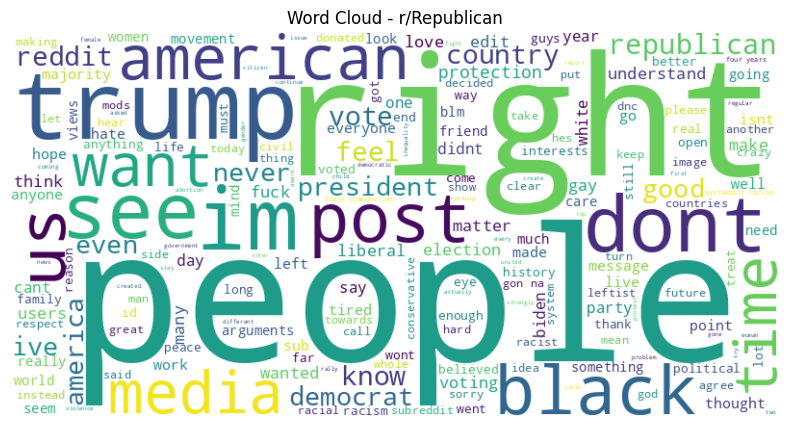

In [ ]:
# Republican Word Cloud
text_rep = ' '.join(df_republican['body_clean'].dropna())
wc_rep = WordCloud(width=800, height=400, background_color='white').generate(text_rep)

plt.figure(figsize=(10, 5))
plt.imshow(wc_rep, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - r/Republican')
plt.show()

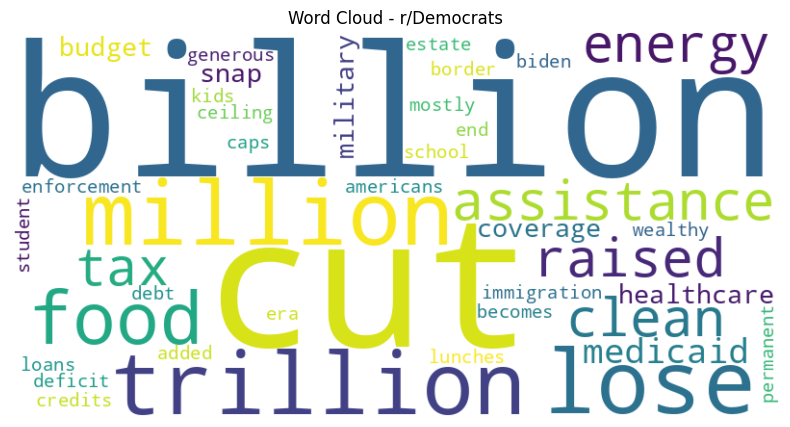

In [ ]:
# Democrat Word Cloud
text_dem = ' '.join(df_democrats['body_clean'].dropna())
wc_dem = WordCloud(width=800, height=400, background_color='white').generate(text_dem)

plt.figure(figsize=(10, 5))
plt.imshow(wc_dem, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - r/Democrats')
plt.show()

# Analyzing Sentiment

In [ ]:
def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

df_republican['sentiment'] = df_republican['body_clean'].apply(analyze_sentiment)
df_democrats['sentiment'] = df_democrats['body_clean'].apply(analyze_sentiment)

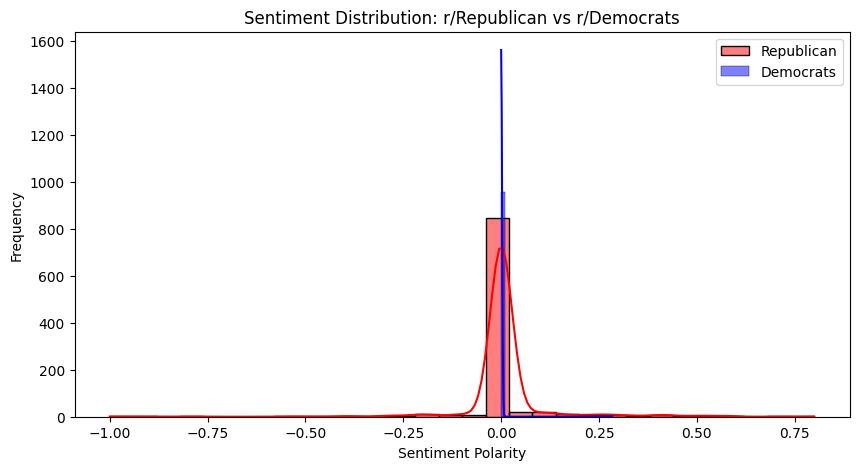

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df_republican['sentiment'], bins=30, kde=True, color='red', label='Republican')
sns.histplot(df_democrats['sentiment'], bins=30, kde=True, color='blue', label='Democrats')
plt.title('Sentiment Distribution: r/Republican vs r/Democrats')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

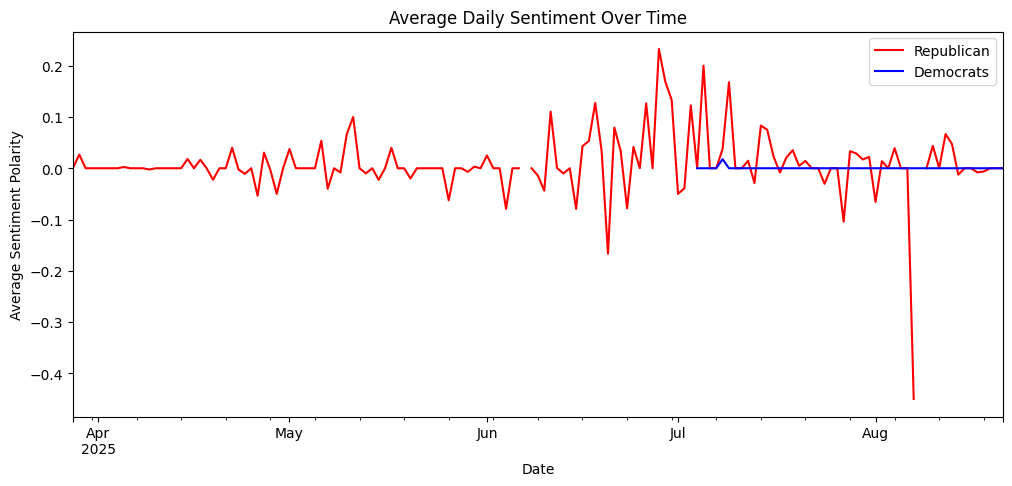

In [ ]:
# Convert timestamps
df_republican['datetime'] = pd.to_datetime(df_republican['created_utc'], unit='s')
df_democrats['datetime'] = pd.to_datetime(df_democrats['created_utc'], unit='s')

# Resample by Day
rep_time = df_republican.set_index('datetime').resample('D')['sentiment'].mean()
dem_time = df_democrats.set_index('datetime').resample('D')['sentiment'].mean()

# Plot
plt.figure(figsize=(12, 5))
rep_time.plot(label='Republican', color='red')
dem_time.plot(label='Democrats', color='blue')
plt.title('Average Daily Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Polarity')
plt.legend()
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine clean text data
all_posts = pd.concat([
    df_republican.assign(subreddit='Republican'),
    df_democrats.assign(subreddit='Democrats')
], ignore_index=True)

documents = all_posts['body_clean'].fillna("")

# Shared vocabulary
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)


In [ ]:
from sklearn.cluster import KMeans

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
all_posts['cluster'] = kmeans.fit_predict(X)


In [ ]:
from textblob import TextBlob

def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

all_posts['sentiment'] = all_posts['body_clean'].apply(analyze_sentiment)


In [ ]:
all_posts['datetime'] = pd.to_datetime(all_posts['created_utc'], unit='s')
all_posts['date'] = all_posts['datetime'].dt.date

# Group by date and cluster
cluster_sentiment_daily = all_posts.groupby(['date', 'cluster'])['sentiment'].mean().unstack(fill_value=0)


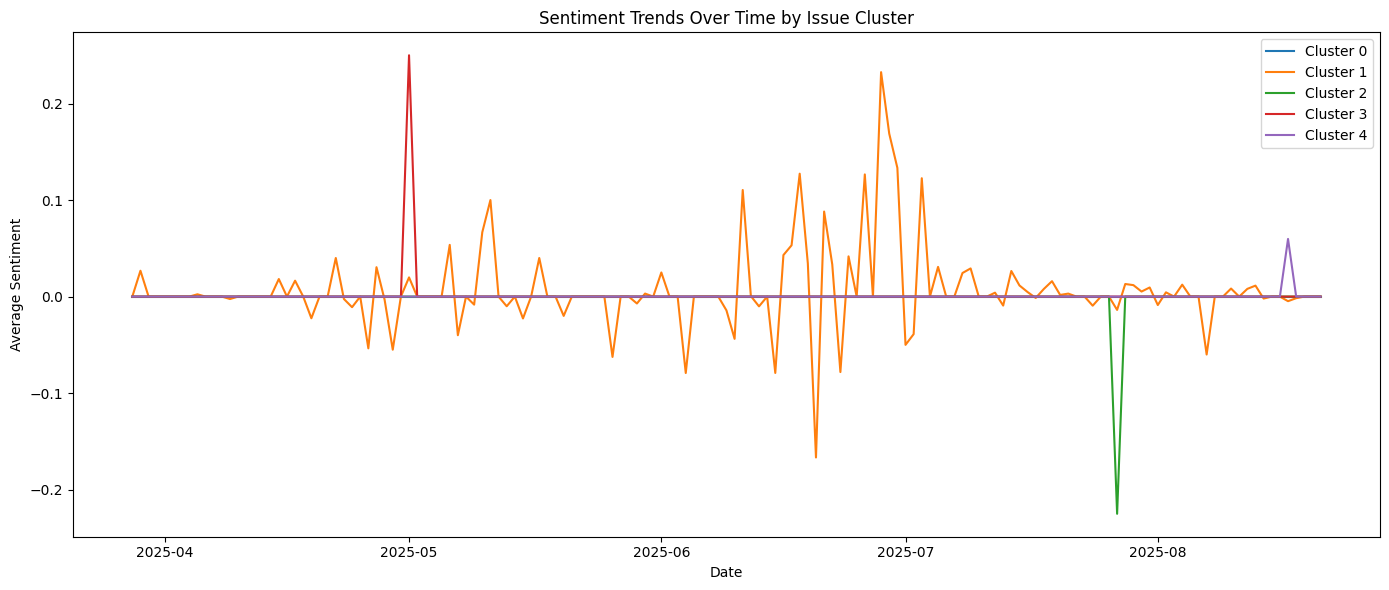

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for cluster_id in cluster_sentiment_daily.columns:
    plt.plot(cluster_sentiment_daily.index, cluster_sentiment_daily[cluster_id], label=f'Cluster {cluster_id}')

plt.title("Sentiment Trends Over Time by Issue Cluster")
plt.xlabel("Date")
plt.ylabel("Average Sentiment")
plt.legend()
plt.tight_layout()
plt.show()


# Clustering

In [ ]:
import numpy as np

centroids = kmeans.cluster_centers_
terms = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    top_terms = [terms[ind] for ind in centroids[i].argsort()[-10:][::-1]]
    print(f"Cluster {i} top terms: {', '.join(top_terms)}")


Cluster 0 top terms: dont, facts, hell, want, fbi, feel, feet, fight, files, financial
Cluster 1 top terms: trump, president, like, american, new, video, people, ice, america, illegal
Cluster 2 top terms: trouble, making, father, fbi, federal, feel, feet, fight, farleft, financial
Cluster 3 top terms: impact, weighs, fox, deal, office, rep, days, news, donald, trumps
Cluster 4 top terms: crowds, protests, company, democrats, years, people, rallies, appear, demand, paid


In [ ]:
pd.crosstab(all_posts['cluster'], all_posts['subreddit'], normalize='index')


subreddit,Democrats,Republican
cluster,,
0,0.000000,1.000000
1,0.496641,0.503359
2,0.000000,1.000000
3,0.000000,1.000000
4,0.000000,1.000000


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

def cluster_issues(texts, k=8, max_features=3000):
    vec = TfidfVectorizer(max_features=max_features, stop_words='english')
    X = vec.fit_transform(texts.fillna(''))
    km = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X)
    terms = vec.get_feature_names_out()
    top_terms = []
    for i, c in enumerate(km.cluster_centers_):
        idx = c.argsort()[-12:][::-1]
        top_terms.append((i, terms[idx]))
    return km.labels_, top_terms

df_republican['cluster_rep'], rep_terms = cluster_issues(df_republican['body_clean'], k=8)
df_democrats['cluster_dem'], dem_terms = cluster_issues(df_democrats['body_clean'], k=8)

print("Republican clusters (top terms):")
for i, terms in rep_terms: print(i, ', '.join(terms))
print("\nDemocrats clusters (top terms):")
for i, terms in dem_terms: print(i, ', '.join(terms))

Republican clusters (top terms):
0 trump, president, american, people, like, dont, israel, illegal, ice, new, iran, video
1 noticed, rchico, primarily, inviting, banned, picture, post, liberals, reddit, fleet, flaws, flashing
2 trouble, making, flimsy, flights, flight, fleet, flaws, flashing, flash, fixing, fix, fitting
3 cards, playing, fafo, flights, flight, fleet, flaws, flashing, flash, fixing, fix, fitting
4 acid, pen, peppers, bites, everyones, auto, lied, hot, faces, lie, dems, continue
5 europe, open, flimsy, flights, flight, fleet, flaws, flashing, flash, fixing, fix, fitting
6 god, bless, america, birthday, happy, usa, th, officers, enforcement, flash, flashing, flaws
7 miserable, bidenharris, cleaning, mess, inherited, term, second, months, years, trumps, fix, flaws

Democrats clusters (top terms):
0 wealthy, trillion, tax, student, snap, school, raised, permanent, million, military, medicaid, lunches
1 billion, trillion, million, cuts, lose, tax, raised, cut, assistance, cl

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

# Combine clean text data from both dataframes
all_posts = pd.concat([
    df_republican.assign(subreddit='Republican'),
    df_democrats.assign(subreddit='Democrats')
], ignore_index=True)

documents = all_posts['body_clean'].fillna("")

# Apply TF-IDF to the combined data
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
X = vectorizer.fit_transform(documents)

# Cluster the combined data
num_clusters = 8  # You can adjust the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
all_posts['cluster'] = kmeans.fit_predict(X)

# Print top terms for each cluster
centroids = kmeans.cluster_centers_
terms = vectorizer.get_feature_names_out()

print("Combined clusters (top terms):")
for i in range(num_clusters):
    top_terms = [terms[ind] for ind in centroids[i].argsort()[-12:][::-1]]
    print(f"Cluster {i} top terms: {', '.join(top_terms)}")

# Pulling Comments

In [ ]:
import praw
from praw.models import MoreComments

def fetch_reddit_comments(reddit, post_ids, per_post=50, sort='top'):
    rows = []
    for pid in post_ids:
        s = reddit.submission(id=pid)
        s.comment_sort = sort
        s.comment_limit = per_post

        for c in s.comments[:per_post]:
            # Skip MoreComments objects
            if isinstance(c, MoreComments):
                continue
            rows.append({
                "post_id": pid,
                "comment_id": c.id,
                "body": c.body or "",
                "author": str(c.author) if c.author else None,
                "score": c.score,
                "created_utc": c.created_utc,
                "is_submitter": getattr(c, "is_submitter", None),
            })
    return pd.DataFrame(rows)

In [ ]:
republican_comments = fetch_reddit_comments(careddit, df_republican["id"].tolist(), per_post=20, sort="new")

In [ ]:
democratic_comments = fetch_reddit_comments(careddit, df_democrats["id"].tolist(), per_post=20, sort="new")

In [ ]:
republican_comments.to_csv("republican_comments.csv", index=False)
democratic_comments.to_csv("democrats_comments.csv", index=False)

In [ ]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        text = ""
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

republican_comments['body_clean'] = df_republican['body'].apply(clean_text)
democratic_comments['body_clean'] = df_democrats['body'].apply(clean_text)

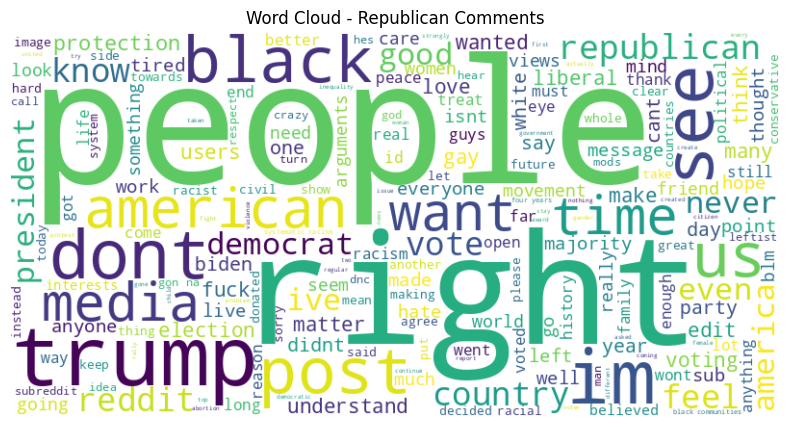

In [ ]:
# Republican Comment Word Cloud
text_rep = ' '.join(republican_comments['body_clean'].dropna())
wc_rep = WordCloud(width=800, height=400, background_color='white').generate(text_rep)

plt.figure(figsize=(10, 5))
plt.imshow(wc_rep, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Republican Comments')
plt.show()

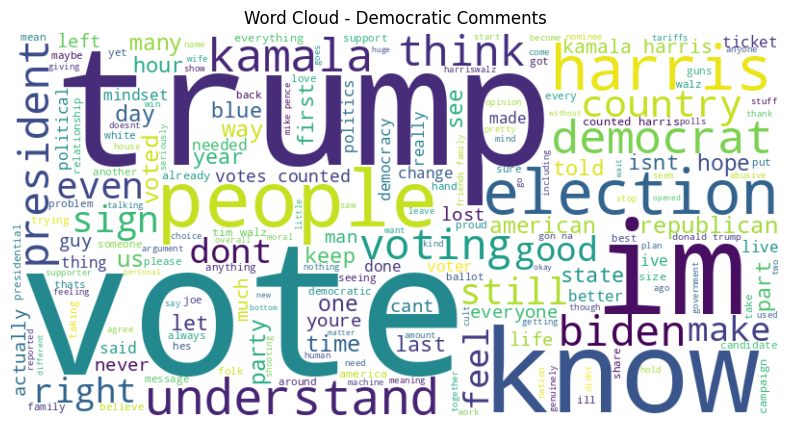

In [ ]:
# Democrat Comments Word Cloud
text_dem = ' '.join(democratic_comments['body_clean'].dropna())
wc_dem = WordCloud(width=800, height=400, background_color='white').generate(text_dem)

plt.figure(figsize=(10, 5))
plt.imshow(wc_dem, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Democratic Comments')
plt.show()

In [ ]:
def analyze_sentiment(text):
  text = "" if not isinstance(text, str) else text
  return TextBlob(text).sentiment.polarity

republican_comments['sentiment'] = republican_comments['body_clean'].apply(analyze_sentiment)
democratic_comments['sentiment'] = democratic_comments['body_clean'].apply(analyze_sentiment)

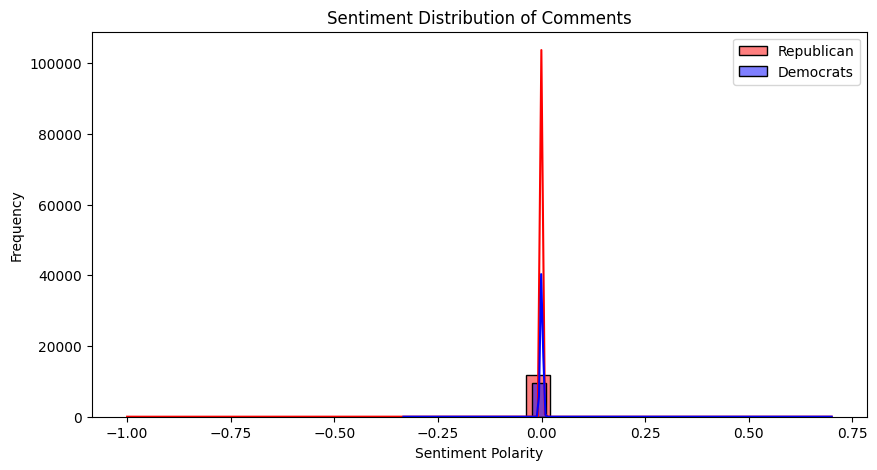

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(republican_comments['sentiment'], bins=30, kde=True, color='red', label='Republican')
sns.histplot(democratic_comments['sentiment'], bins=30, kde=True, color='blue', label='Democrats')
plt.title('Sentiment Distribution of Comments')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

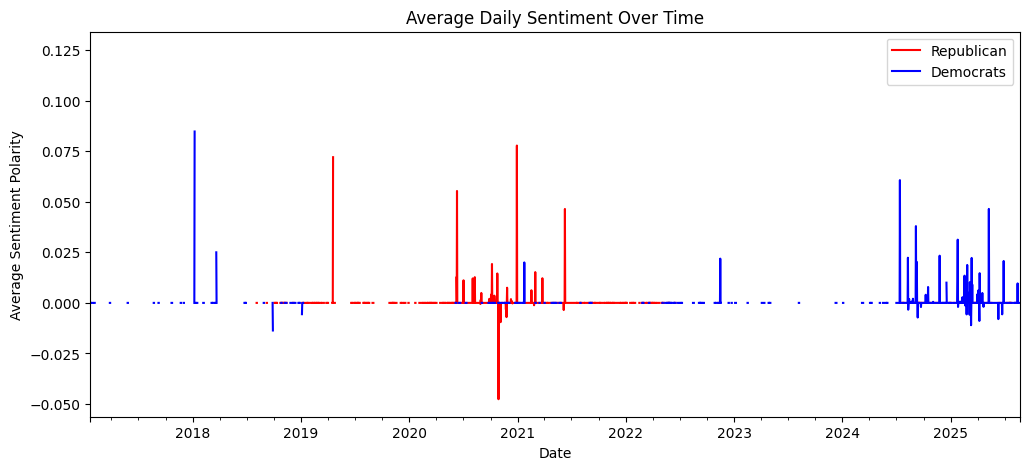

In [ ]:
# Convert timestamps
republican_comments['datetime'] = pd.to_datetime(republican_comments['created_utc'], unit='s')
democratic_comments['datetime'] = pd.to_datetime(democratic_comments['created_utc'], unit='s')

# Resample by Day
rep_time = republican_comments.set_index('datetime').resample('D')['sentiment'].mean()
dem_time = democratic_comments.set_index('datetime').resample('D')['sentiment'].mean()

# Plot
plt.figure(figsize=(12, 5))
rep_time.plot(label='Republican', color='red')
dem_time.plot(label='Democrats', color='blue')
plt.title('Average Daily Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Polarity')
plt.legend()
plt.show()

In [ ]:
# Combine clean text data
all_comments = pd.concat([
    republican_comments.assign(subreddit='Republican'),
    democratic_comments.assign(subreddit='Democrats')
], ignore_index=True)

comment_documents = all_comments['body_clean'].fillna("")

# Shared vocabulary
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(comment_documents)

In [ ]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
all_comments['cluster'] = kmeans.fit_predict(X)

In [ ]:
def analyze_sentiment(text):
  text = "" if not isinstance(text, str) else text
  return TextBlob(text).sentiment.polarity

all_comments['sentiment'] = all_comments['body_clean'].apply(analyze_sentiment)

In [ ]:
all_comments['datetime'] = pd.to_datetime(all_comments['created_utc'], unit='s')
all_comments['date'] = all_comments['datetime'].dt.date

# Group by date and cluster
comment_daily_sentiment = all_comments.groupby(['date', 'cluster'])['sentiment'].mean().unstack(fill_value=0)

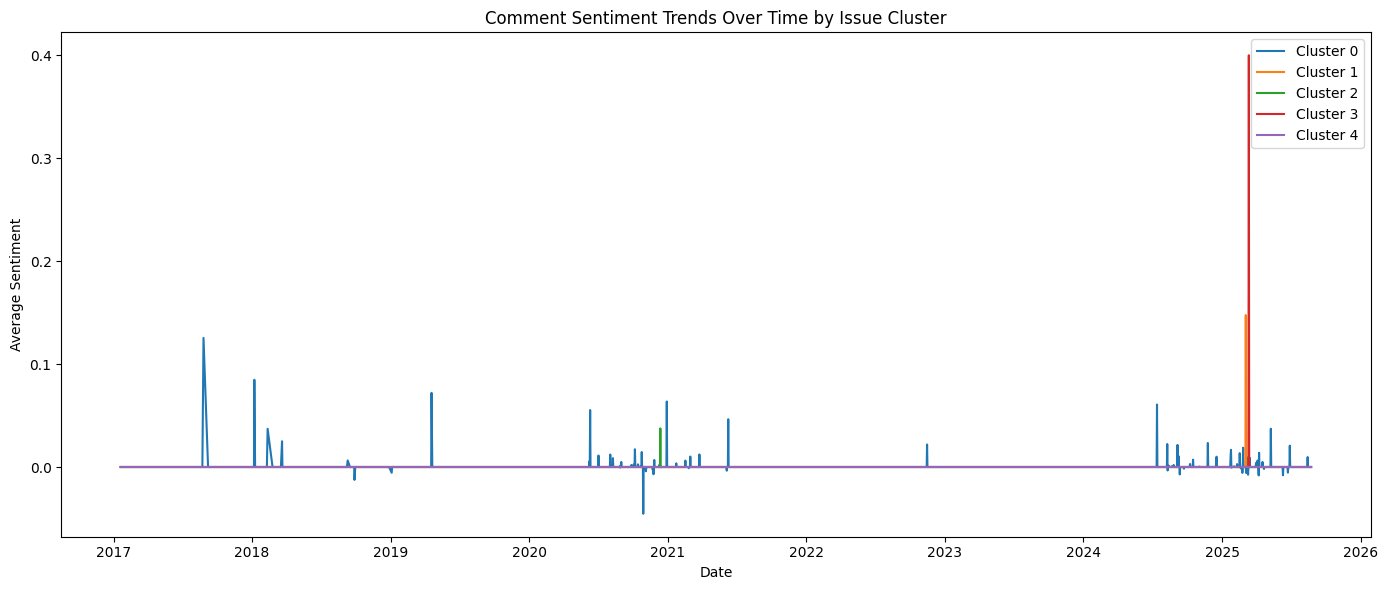

In [ ]:
plt.figure(figsize=(14, 6))
for cluster_id in comment_daily_sentiment.columns:
    plt.plot(comment_daily_sentiment.index, comment_daily_sentiment[cluster_id], label=f'Cluster {cluster_id}')

plt.title("Comment Sentiment Trends Over Time by Issue Cluster")
plt.xlabel("Date")
plt.ylabel("Average Sentiment")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
centroids = kmeans.cluster_centers_
terms = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    top_terms = [terms[ind] for ind in centroids[i].argsort()[-10:][::-1]]
    print(f"Cluster {i} top terms: {', '.join(top_terms)}")

Cluster 0 top terms: trump, people, im, vote, like, dont, voting, know, republican, harris
Cluster 1 top terms: place, general, morning, opened, entire, meaning, early, tim, walz, voted
Cluster 2 top terms: post, trump, elon, look, im, immediately, banned, used, senate, pushed
Cluster 3 top terms: asking, isnt, understand, trump, hi, genuine, hostility, course, fact, everyones
Cluster 4 top terms: registered, citizen, today, republican, gooooo, gop, got, gotten, gov, govern
